# Train the StarNet Model

This notebook takes you through the steps of how to train a StarNet Model
- Required Python packages: `numpy h5py keras`
- Required data files: training_data.h5, mean_and_std.npy

Note: We use tensorflow for the keras backend.

In [69]:
import numpy as np
import h5py
import random
import keras
from keras.models import Model
from keras.layers import Input, Dense, InputLayer, Flatten, Reshape, Concatenate, concatenate
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.optimizers import Adam
import tensorflow as tf
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.utils import HDF5Matrix
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc


#Loading the data

#RVSFlux normalized
pathrvs = 'norm_rvsflux.h5'
readrvs = h5py.File(pathrvs, 'r')
print(readrvs.keys())
rvs = readrvs.get('normrvs')
norm_rvsflux = np.array(rvs)
readrvs.close()

type(rvs)
print('shape of rvsflux:', np.shape(norm_rvsflux))


<KeysViewHDF5 ['normrvs']>
shape of rvsflux: (415, 1134)


In [70]:

#BPFlux noiseless
pathbp = '/Users/aishasultan/work/synple-gaia/run/flux_feh0/bpflux.h5'
readbp = h5py.File(pathbp, 'r')
#print('total number of wave and flux in the folder:'len(readbp.keys()))
bpflux = readbp.get('bpflux0')
bpflux = np.array(bpflux)


norm_bpflux= []

for ii in range(np.shape(norm_rvsflux)[0]):
    #if ii%50 == 0: #i=i/100
        #print('star #',ii)
        fluxlabel = 'bpflux'+str(ii)
        wavelabel = 'bpwave' +str(ii)
        flux = readbp.get(fluxlabel)
        wave= readbp.get(wavelabel)
    
        
        flux = np.array(flux)
        wave = np.array(wave)
        #print('flux is:', flux)
        
        max_flux=np.max(flux)
        #print('maxflux:', max_flux)
        normflux = flux/ max_flux
        #print('normflux:',normflux)
        
        
        
        #plt.plot(wave, flux)
        #plt.scatter(wave,flux, color='red')
        #plt.show()
    
        
        norm_bpflux.append(normflux)


        
norm_bpflux= np.array(norm_bpflux)

print('shape of norm bpflux:', np.shape(norm_bpflux))
#print('shape of norm bpflux:', print(norm_bpflux[0:10]))









shape of norm bpflux: (415, 53)


In [71]:
#RPFlux
pathrp = '/Users/aishasultan/work/synple-gaia/run/flux_feh0/rpflux.h5'
readrp = h5py.File(pathrp, 'r')
#print('total number of wave and flux in the folder:'len(readbp.keys()))
rpflux = readrp.get('rpflux0')
rpflux = np.array(rpflux)


norm_rpflux= []

for ii in range(np.shape(norm_rvsflux)[0]):
    #if ii%50 == 0: #i=i/100
        #print('star:',ii)
        fluxlabel = 'rpflux'+str(ii)
        wavelabel = 'rpwave' +str(ii)
        
        flux = readrp.get(fluxlabel)
        wave= readrp.get(wavelabel)
    
        
        flux = np.array(flux)
        wave = np.array(wave)
        #print('flux is:', flux)
        
        max_flux=np.max(flux)
        #print('maxflux:', max_flux)
        normflux = flux/ max_flux
        #print('normflux:',normflux)
        
        
        
        #plt.plot(wave, flux)
        #plt.scatter(wave,flux, color='red')
        #plt.show()
    
        
        norm_rpflux.append(normflux)


        
norm_rpflux= np.array(norm_rpflux)

print('shape of norm_rpflux:', np.shape(norm_rpflux))
#print('output of norm_flux:', print(norm_rpflux[0:10]))

#print('The shapes of features and labels:', np.shape(norm_flux), np.shape(logteff))





shape of norm_rpflux: (415, 49)


In [72]:
#LogTeff
modparam = 'modparam_feh0.h5' #model parameters includes log g and teff
readfile = h5py.File(modparam, 'r')
print(readfile.keys())
teff = readfile.get('teff')
teff = np.array(teff)
logg = readfile.get('logg')
logg = np.array(logg)
print(teff)
readfile.close()


<KeysViewHDF5 ['logg', 'teff']>
[ 3500.  3500.  3500.  3500.  3500.  3500.  3500.  3500.  3500.  3500.
  3500.  3750.  3750.  3750.  3750.  3750.  3750.  3750.  3750.  3750.
  3750.  3750.  4000.  4000.  4000.  4000.  4000.  4000.  4000.  4000.
  4000.  4000.  4000.  4250.  4250.  4250.  4250.  4250.  4250.  4250.
  4250.  4250.  4250.  4250.  4500.  4500.  4500.  4500.  4500.  4500.
  4500.  4500.  4500.  4500.  4500.  4750.  4750.  4750.  4750.  4750.
  4750.  4750.  4750.  4750.  4750.  4750.  5000.  5000.  5000.  5000.
  5000.  5000.  5000.  5000.  5000.  5000.  5000.  5250.  5250.  5250.
  5250.  5250.  5250.  5250.  5250.  5250.  5250.  5250.  5500.  5500.
  5500.  5500.  5500.  5500.  5500.  5500.  5500.  5500.  5500.  5750.
  5750.  5750.  5750.  5750.  5750.  5750.  5750.  5750.  5750.  5750.
  6000.  6000.  6000.  6000.  6000.  6000.  6000.  6000.  6000.  6000.
  6000.  6250.  6250.  6250.  6250.  6250.  6250.  6250.  6250.  6250.
  6500.  6500.  6500.  6500.  6500.  6500.  6

total number of input stars = 415
number of RVS training data= 331
number of BP training data= 331
number of RP training data= 331
The size of CVS for the input flux data
RVS cvs= (84, 1134)
BP cvs= (84, 53)
RP cvs= (84, 49)
the size of output label= (331,)


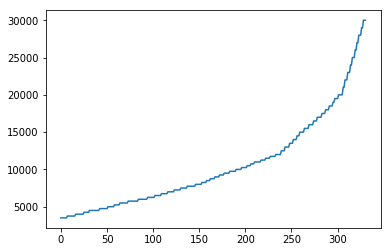

In [73]:

#features
num_tot = len(teff)
print('total number of input stars =', num_tot)
plim = 0.8
ran_frac = np.random.uniform(0,1,num_tot)
#print('ranfrac=' , ran_frac)




#Input flux data of RVS, BP, RP
x_RVStrain = norm_rvsflux[ran_frac < plim, :]
print('number of RVS training data=', len(x_RVStrain[:,0]))
x_RVScv = norm_rvsflux[ran_frac >= plim, :] #test set we left for the application

x_BPtrain = norm_bpflux[ran_frac < plim, :]
print('number of BP training data=', len(x_BPtrain[:,0]))
x_BPcv = norm_bpflux[ran_frac >= plim, :]

x_RPtrain =norm_rpflux[ran_frac < plim, :]
print('number of RP training data=', len(x_RPtrain[:,0]))
x_RPcv = norm_rpflux[ran_frac >= plim, :]


#print('x_BPtrain', x_BPtrain)

#x_train_combined = np.vstack (x_RVStrain[0,:],x_RPtrain[0,:]) 

#output label which is the logteff and log g
y_teff_train = teff[ran_frac< plim]
y_teff_cv = teff[ran_frac >= plim] #test set

y_logg_train = logg[ran_frac< plim]
y_logg_cv = logg[ran_frac >= plim] #test set



print('The size of CVS for the input flux data')
print('RVS cvs=', np.shape(x_RVScv))
print('BP cvs=', np.shape(x_BPcv))
print('RP cvs=', np.shape(x_RPcv))

print('the size of output label=', np.shape(y_teff_train) )

id = np.linspace(0, len(x_RVStrain[:, 0])-1, len(x_RVStrain[:, 0]))
plt.plot(id, y_teff_train)
plt.show()


** Normalization **

Write a function to normalize the output labels. Each label will be normalized to have approximately have a mean of zero and unit variance.

NOTE: This is necessary to put output labels on a similar scale in order for the model to train properly, this process is reversed in the test stage to give the output labels their proper units

In [74]:
#mean_labels=np.mean(logteff)
#std_labels=np.std(logteff)
#print('mean and std teff=', mean_labels, std_labels)
def normalize(labels, mean_label, std_label):
    # Normalize labels
    return (labels-mean_label) / std_label

def denormalize(labels, mean_label, std_label):
    return (((labels)*(std_label)) + mean_label)





In [75]:
#normalize the y labels, the log teff and log g 

#labels trained
mean_teff_train = np.mean(y_teff_train)
std_teff_train = np.std(y_teff_train)

mean_logg_train = np.mean(y_logg_train)
std_logg_train = np.std(y_logg_train)

#labels cv
#mean_teff_cv = np.mean(y_teff_cv)
#std_teff_cv = np.std(y_teff_cv)

#mean_logg_cv = np.mean(y_logg_cv)
#std_logg_cv = np.std(y_logg_cv)

#output label which is the logteff and log g
y_teff_train = normalize(y_teff_train, mean_teff_train, std_teff_train)
y_teff_cv = normalize(y_teff_cv, mean_teff_train, std_teff_train)

y_logg_train = normalize(y_logg_train, mean_logg_train, std_logg_train)
y_logg_cv = normalize(y_logg_cv, mean_logg_train, std_logg_train)


print('type of data ', type(y_teff_train),type(y_teff_cv), type(y_logg_train), type(y_logg_cv) )


type of data  <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


**Build the StarNet model architecture**

The StarNet architecture is built with:
- input layer
- 2 convolutional layers
- 1 maxpooling layer followed by flattening for the fully connected layer
- 2 fully connected layers
- output layer

First, let's define some model variables.

In [76]:
# activation function used following every layer except for the output layers
activation = 'relu'
#activation = 'sigmoid'

# model weight initializer
initializer = 'he_normal'

# number of filters used in the convolutional layers
#num_filters = [4,16]
num_filters = [8,32]
#num_filters = [8,16]

# length of the filters in the convolutional layers
#filter_length = 8
#filter_length = 16
filter_length = 8

# length of the maxpooling window 
pool_length_rvs = 4

pool_length_bp = 3

pool_length_rp = 3

# number of nodes in each of the hidden fully connected layers
num_hidden = [256,128]
#num_hidden = [24,12]

# number of spectra fed into model at once during training
batch_size = 64

# maximum number of interations for model training
#max_epochs = 200
#max_epochs = 100
#max_epochs = 150 
#max_epochs = 350
#max_epochs = 225
#max_epochs = 180
#max_epochs = 450
#max_epochs = 300
max_epochs = 300


# initial learning rate for optimization algorithm
lr = 0.000003 #handled by Adam
    
# exponential decay rate for the 1st moment estimates for optimization algorithm
beta_1 = 0.9

# exponential decay rate for the 2nd moment estimates for optimization algorithm
beta_2 = 0.999

# a small constant for numerical stability for optimization algorithm
optimizer_epsilon = 1e-08

In [77]:
num_RVSfluxes=len(x_RVStrain[0,:]) 
print('number of RVS fluxes=', num_RVSfluxes)

num_BPfluxes=len(x_BPtrain[0,:]) 
print('number of BP fluxes=', num_BPfluxes)

num_RPfluxes=len(x_RPtrain[0,:]) 
print('number of RP fluxes=', num_RPfluxes)

#num_labels= 1
num_labels= 2
print('number of training labels=', num_labels)

#ilam = np.linspace(0, num_fluxes-1, num_fluxes)
#plt.plot(ilam, x_train[329, :])
#plt.plot()

#iy = np.linspace(0, len(y_train)-1, len(y_train))
#plt.plot(iy, y_train)
#plt.plot()


number of RVS fluxes= 1134
number of BP fluxes= 53
number of RP fluxes= 49
number of training labels= 2


In [78]:

# Input RVS spectra
# print(' num_RVSfluxes=', num_RVSfluxes)
input_RVSspec = Input(shape=(num_RVSfluxes,), name='rvs_input_x' ) #removed name='starnet_input_x'

# Reshape spectra for RVS layers
cur_rvs = Reshape((num_RVSfluxes, 1))(input_RVSspec)

# CNN layers
cur_rvs = Conv1D(kernel_initializer=initializer, activation=activation, 
                padding="same", filters=num_filters[0], kernel_size=filter_length)(cur_rvs) #first CNN layer
cur_rvs = Conv1D(kernel_initializer=initializer, activation=activation,
                padding="same", filters=num_filters[1], kernel_size=filter_length)(cur_rvs) #2nd CNN layer

# Max pooling layer
cur_rvs = MaxPooling1D(pool_size=pool_length_rvs)(cur_rvs)

# Flatten the current input for the fully-connected layers
cur_rvs = Flatten()(cur_rvs)


##############################################################################################


# Input BP spectra
# print(' num_BPfluxes=', num_BPfluxes)
input_BPspec = Input(shape=(num_BPfluxes,), name='bp_input_x' ) #removed name='starnet_input_x'

# Reshape spectra for BP layers
cur_bp = Reshape((num_BPfluxes, 1))(input_BPspec)

# CNN layers
cur_bp = Conv1D(kernel_initializer=initializer, activation=activation, 
                padding="same", filters=num_filters[0], kernel_size=filter_length)(cur_bp) #first CNN layer
cur_bp = Conv1D(kernel_initializer=initializer, activation=activation,
                padding="same", filters=num_filters[1], kernel_size=filter_length)(cur_bp) #2nd CNN layer

# Max pooling layer
cur_bp = MaxPooling1D(pool_size=pool_length_bp)(cur_bp)


# Flatten the current input for the fully-connected layers
cur_bp = Flatten()(cur_bp)


################################################################################################

# Input RP spectra
input_RPspec = Input(shape=(num_RPfluxes,), name='rp_input_x' ) #removed name='starnet_input_x'

# Reshape spectra for CNN layers
cur_rp = Reshape((num_RPfluxes, 1))(input_RPspec)

# CNN layers
cur_rp = Conv1D(kernel_initializer=initializer, activation=activation, 
                padding="same", filters=num_filters[0], kernel_size=filter_length)(cur_rp) #first CNN layer
cur_rp = Conv1D(kernel_initializer=initializer, activation=activation,
                padding="same", filters=num_filters[1], kernel_size=filter_length)(cur_rp) #2nd CNN layer

# Max pooling layer
cur_rp = MaxPooling1D(pool_size=pool_length_rp)(cur_rp)

# Flatten the current input for the fully-connected layers
cur_rp = Flatten()(cur_rp)

###############################################################################################

#concatenate RVS/BP/RP and then insert it to dense layer 

cur_comb = concatenate([cur_rvs, cur_bp, cur_rp])

# Fully-connected layers
cur_final = Dense(units=num_hidden[0], kernel_initializer=initializer, 
               activation=activation)(cur_comb)
cur_final = Dense(units=num_hidden[1], kernel_initializer=initializer, 
               activation=activation)(cur_final)

# Output nodes
output_final = Dense(units=num_labels, activation="linear", 
                    input_dim=num_hidden[1], name='output_y')(cur_final)


model = Model(inputs = [input_RVSspec, input_BPspec, input_RPspec], outputs=output_final)






**More model techniques**
* The `Adam` optimizer is the gradient descent algorithm used for minimizing the loss function
* `EarlyStopping` uses the cross-validation set to test the model following every iteration and stops the training if the cv loss does not decrease by `min_delta` after `patience` iterations
* `ReduceLROnPlateau` is a form of learning rate decay where the learning rate is decreased by a factor of `factor` if the training loss does not decrease by `epsilon` after `patience` iterations unless the learning rate has reached `min_lr`

In [79]:
# Default loss function parameters
early_stopping_min_delta = 0.0007
early_stopping_patience = 4
reduce_lr_factor = 0.5
reuce_lr_epsilon = 0.0000009
reduce_lr_patience = 2
reduce_lr_min = 0.00008

# loss function to minimize
loss_function = 'mean_squared_error'

# compute mean absolute deviation
metrics = ['mae', 'mse']
#metrics = ['mae']

In [80]:
#optimizer = Adam(lr=lr, beta_1=beta_1, beta_2=beta_2, epsilon=optimizer_epsilon, decay=0.0)
optimizer = Adam(lr=0.005 )

early_stopping = EarlyStopping(monitor='val_loss', min_delta=early_stopping_min_delta, 
                                       patience=early_stopping_patience, verbose=2, mode='min')

reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, epsilon=reuce_lr_epsilon, 
                                  patience=reduce_lr_patience, min_lr=reduce_lr_min, mode='min', verbose=2)

**Compile model**

In [81]:
model.compile(optimizer=optimizer, loss=loss_function, metrics=metrics)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
rvs_input_x (InputLayer)        (None, 1134)         0                                            
__________________________________________________________________________________________________
bp_input_x (InputLayer)         (None, 53)           0                                            
__________________________________________________________________________________________________
rp_input_x (InputLayer)         (None, 49)           0                                            
__________________________________________________________________________________________________
reshape_10 (Reshape)            (None, 1134, 1)      0           rvs_input_x[0][0]                
__________________________________________________________________________________________________
reshape_11

**Train model**

In [82]:

#history = model.fit(x_train, y_train, validation_data=(x_cv, y_cv),
          #epochs=max_epochs, verbose=1, shuffle='batch',
         #callbacks=[early_stopping, reduce_lr])
        

y_train_stack = np.column_stack((y_teff_train, y_logg_train))
y_cv_stack = np.column_stack ((y_teff_cv, y_logg_cv))

print('shape of the cv teff and logg=', np.shape(y_cv_stack))
print(' shape of y teff and logg=', np.shape(y_train_stack))
#history = model.fit(x=[x_RVStrain, x_BPtrain, x_RPtrain], y=y_train_stack,
          #validation_split=0.2, epochs=max_epochs, verbose=1, shuffle='batch')
        
history = model.fit(x=[x_RVStrain, x_BPtrain, x_RPtrain], y= y_train_stack, 
                    validation_data=([x_RVScv, x_BPcv, x_RPcv], y_cv_stack),
          epochs=max_epochs, verbose=1, shuffle='batch')



shape of the cv teff and logg= (84, 2)
 shape of y teff and logg= (331, 2)
Train on 331 samples, validate on 84 samples
Epoch 1/300
331/331 [==============================] - 2s 6ms/step - loss: 1593.2911 - mean_absolute_error: 17.5328 - mean_squared_error: 1593.2911 - val_loss: 37.5023 - val_mean_absolute_error: 5.2809 - val_mean_squared_error: 37.5023
Epoch 2/300
331/331 [==============================] - 0s 1ms/step - loss: 14.1522 - mean_absolute_error: 3.1215 - mean_squared_error: 14.1522 - val_loss: 5.4493 - val_mean_absolute_error: 1.8215 - val_mean_squared_error: 5.4493
Epoch 3/300
331/331 [==============================] - 0s 1ms/step - loss: 2.8246 - mean_absolute_error: 1.2910 - mean_squared_error: 2.8246 - val_loss: 15.4691 - val_mean_absolute_error: 3.2154 - val_mean_squared_error: 15.4691
Epoch 4/300
331/331 [==============================] - 0s 1ms/step - loss: 5.6119 - mean_absolute_error: 1.8694 - mean_squared_error: 5.6119 - val_loss: 10.4789 - val_mean_absolute_error

331/331 [==============================] - 0s 1ms/step - loss: 0.0355 - mean_absolute_error: 0.1382 - mean_squared_error: 0.0355 - val_loss: 0.1060 - val_mean_absolute_error: 0.2179 - val_mean_squared_error: 0.1060
Epoch 37/300
331/331 [==============================] - 0s 1ms/step - loss: 0.0730 - mean_absolute_error: 0.1875 - mean_squared_error: 0.0730 - val_loss: 0.1166 - val_mean_absolute_error: 0.2457 - val_mean_squared_error: 0.1166
Epoch 38/300
331/331 [==============================] - 0s 1ms/step - loss: 0.0782 - mean_absolute_error: 0.2040 - mean_squared_error: 0.0782 - val_loss: 0.0648 - val_mean_absolute_error: 0.1807 - val_mean_squared_error: 0.0648
Epoch 39/300
331/331 [==============================] - 0s 1ms/step - loss: 0.0627 - mean_absolute_error: 0.1805 - mean_squared_error: 0.0627 - val_loss: 0.1372 - val_mean_absolute_error: 0.2451 - val_mean_squared_error: 0.1372
Epoch 40/300
331/331 [==============================] - 0s 1ms/step - loss: 0.0861 - mean_absolute_er

Epoch 72/300
331/331 [==============================] - 0s 1ms/step - loss: 0.0373 - mean_absolute_error: 0.1399 - mean_squared_error: 0.0373 - val_loss: 0.0400 - val_mean_absolute_error: 0.1594 - val_mean_squared_error: 0.0400
Epoch 73/300
331/331 [==============================] - 0s 1ms/step - loss: 0.0334 - mean_absolute_error: 0.1425 - mean_squared_error: 0.0334 - val_loss: 0.0229 - val_mean_absolute_error: 0.1247 - val_mean_squared_error: 0.0229
Epoch 74/300
331/331 [==============================] - 0s 1ms/step - loss: 0.0199 - mean_absolute_error: 0.1079 - mean_squared_error: 0.0199 - val_loss: 0.0288 - val_mean_absolute_error: 0.1273 - val_mean_squared_error: 0.0288
Epoch 75/300
331/331 [==============================] - 0s 1ms/step - loss: 0.0213 - mean_absolute_error: 0.1090 - mean_squared_error: 0.0213 - val_loss: 0.0221 - val_mean_absolute_error: 0.1036 - val_mean_squared_error: 0.0221
Epoch 76/300
331/331 [==============================] - 0s 1ms/step - loss: 0.0250 - mea

Epoch 108/300
331/331 [==============================] - 0s 1ms/step - loss: 0.0118 - mean_absolute_error: 0.0806 - mean_squared_error: 0.0118 - val_loss: 0.0129 - val_mean_absolute_error: 0.0825 - val_mean_squared_error: 0.0129
Epoch 109/300
331/331 [==============================] - 0s 1ms/step - loss: 0.0123 - mean_absolute_error: 0.0846 - mean_squared_error: 0.0123 - val_loss: 0.0132 - val_mean_absolute_error: 0.0834 - val_mean_squared_error: 0.0132
Epoch 110/300
331/331 [==============================] - 0s 1ms/step - loss: 0.0117 - mean_absolute_error: 0.0830 - mean_squared_error: 0.0117 - val_loss: 0.0119 - val_mean_absolute_error: 0.0790 - val_mean_squared_error: 0.0119
Epoch 111/300
331/331 [==============================] - 0s 1ms/step - loss: 0.0101 - mean_absolute_error: 0.0723 - mean_squared_error: 0.0101 - val_loss: 0.0134 - val_mean_absolute_error: 0.0832 - val_mean_squared_error: 0.0134
Epoch 112/300
331/331 [==============================] - 0s 1ms/step - loss: 0.0086 

Epoch 144/300
331/331 [==============================] - 0s 1ms/step - loss: 0.0292 - mean_absolute_error: 0.1254 - mean_squared_error: 0.0292 - val_loss: 0.0393 - val_mean_absolute_error: 0.1396 - val_mean_squared_error: 0.0393
Epoch 145/300
331/331 [==============================] - 0s 1ms/step - loss: 0.0238 - mean_absolute_error: 0.1077 - mean_squared_error: 0.0238 - val_loss: 0.0264 - val_mean_absolute_error: 0.1184 - val_mean_squared_error: 0.0264
Epoch 146/300
331/331 [==============================] - 0s 1ms/step - loss: 0.0238 - mean_absolute_error: 0.1105 - mean_squared_error: 0.0238 - val_loss: 0.0115 - val_mean_absolute_error: 0.0768 - val_mean_squared_error: 0.0115
Epoch 147/300
331/331 [==============================] - 0s 1ms/step - loss: 0.0159 - mean_absolute_error: 0.0922 - mean_squared_error: 0.0159 - val_loss: 0.0227 - val_mean_absolute_error: 0.1053 - val_mean_squared_error: 0.0227
Epoch 148/300
331/331 [==============================] - 0s 1ms/step - loss: 0.0180 

Epoch 180/300
331/331 [==============================] - 0s 1ms/step - loss: 0.0179 - mean_absolute_error: 0.0948 - mean_squared_error: 0.0179 - val_loss: 0.0252 - val_mean_absolute_error: 0.1113 - val_mean_squared_error: 0.0252
Epoch 181/300
331/331 [==============================] - 0s 1ms/step - loss: 0.0235 - mean_absolute_error: 0.1123 - mean_squared_error: 0.0235 - val_loss: 0.0117 - val_mean_absolute_error: 0.0833 - val_mean_squared_error: 0.0117
Epoch 182/300
331/331 [==============================] - 0s 1ms/step - loss: 0.0326 - mean_absolute_error: 0.1234 - mean_squared_error: 0.0326 - val_loss: 0.0216 - val_mean_absolute_error: 0.1131 - val_mean_squared_error: 0.0216
Epoch 183/300
331/331 [==============================] - 0s 1ms/step - loss: 0.0235 - mean_absolute_error: 0.1190 - mean_squared_error: 0.0235 - val_loss: 0.0185 - val_mean_absolute_error: 0.1004 - val_mean_squared_error: 0.0185
Epoch 184/300
331/331 [==============================] - 0s 1ms/step - loss: 0.0235 

Epoch 216/300
331/331 [==============================] - 0s 1ms/step - loss: 0.0216 - mean_absolute_error: 0.1194 - mean_squared_error: 0.0216 - val_loss: 0.0287 - val_mean_absolute_error: 0.1298 - val_mean_squared_error: 0.0287
Epoch 217/300
331/331 [==============================] - 0s 1ms/step - loss: 0.0251 - mean_absolute_error: 0.1202 - mean_squared_error: 0.0251 - val_loss: 0.0306 - val_mean_absolute_error: 0.1171 - val_mean_squared_error: 0.0306
Epoch 218/300
331/331 [==============================] - 0s 1ms/step - loss: 0.0183 - mean_absolute_error: 0.1027 - mean_squared_error: 0.0183 - val_loss: 0.0169 - val_mean_absolute_error: 0.0953 - val_mean_squared_error: 0.0169
Epoch 219/300
331/331 [==============================] - 0s 1ms/step - loss: 0.0194 - mean_absolute_error: 0.1013 - mean_squared_error: 0.0194 - val_loss: 0.0266 - val_mean_absolute_error: 0.1254 - val_mean_squared_error: 0.0266
Epoch 220/300
331/331 [==============================] - 0s 1ms/step - loss: 0.0219 

Epoch 252/300
331/331 [==============================] - 0s 1ms/step - loss: 0.0072 - mean_absolute_error: 0.0673 - mean_squared_error: 0.0072 - val_loss: 0.0068 - val_mean_absolute_error: 0.0633 - val_mean_squared_error: 0.0068
Epoch 253/300
331/331 [==============================] - 0s 1ms/step - loss: 0.0091 - mean_absolute_error: 0.0700 - mean_squared_error: 0.0091 - val_loss: 0.0102 - val_mean_absolute_error: 0.0748 - val_mean_squared_error: 0.0102
Epoch 254/300
331/331 [==============================] - 0s 1ms/step - loss: 0.0127 - mean_absolute_error: 0.0812 - mean_squared_error: 0.0127 - val_loss: 0.0136 - val_mean_absolute_error: 0.0884 - val_mean_squared_error: 0.0136
Epoch 255/300
331/331 [==============================] - 0s 1ms/step - loss: 0.0108 - mean_absolute_error: 0.0740 - mean_squared_error: 0.0108 - val_loss: 0.0106 - val_mean_absolute_error: 0.0779 - val_mean_squared_error: 0.0106
Epoch 256/300
331/331 [==============================] - 0s 1ms/step - loss: 0.0091 

Epoch 288/300
331/331 [==============================] - 0s 1ms/step - loss: 0.0126 - mean_absolute_error: 0.0862 - mean_squared_error: 0.0126 - val_loss: 0.0137 - val_mean_absolute_error: 0.0879 - val_mean_squared_error: 0.0137
Epoch 289/300
331/331 [==============================] - 0s 1ms/step - loss: 0.0109 - mean_absolute_error: 0.0817 - mean_squared_error: 0.0109 - val_loss: 0.0086 - val_mean_absolute_error: 0.0741 - val_mean_squared_error: 0.0086
Epoch 290/300
331/331 [==============================] - 0s 1ms/step - loss: 0.0082 - mean_absolute_error: 0.0664 - mean_squared_error: 0.0082 - val_loss: 0.0107 - val_mean_absolute_error: 0.0696 - val_mean_squared_error: 0.0107
Epoch 291/300
331/331 [==============================] - 0s 1ms/step - loss: 0.0157 - mean_absolute_error: 0.0862 - mean_squared_error: 0.0157 - val_loss: 0.0260 - val_mean_absolute_error: 0.1100 - val_mean_squared_error: 0.0260
Epoch 292/300
331/331 [==============================] - 0s 1ms/step - loss: 0.0202 

In [84]:
hist = pd.DataFrame(history.history)
hist['epoch']= history.epoch
hist.tail()

,val_loss,val_mean_absolute_error,val_mean_squared_error,loss,mean_absolute_error,mean_squared_error,epoch
295,0.027912,0.112933,0.027912,0.013431,0.083175,0.013431,295
296,0.031043,0.130878,0.031043,0.031746,0.121496,0.031746,296
297,0.012818,0.070083,0.012818,0.023604,0.103015,0.023604,297
298,0.013793,0.080827,0.013793,0.011227,0.071488,0.011227,298
299,0.006923,0.055534,0.006923,0.010173,0.073876,0.010173,299


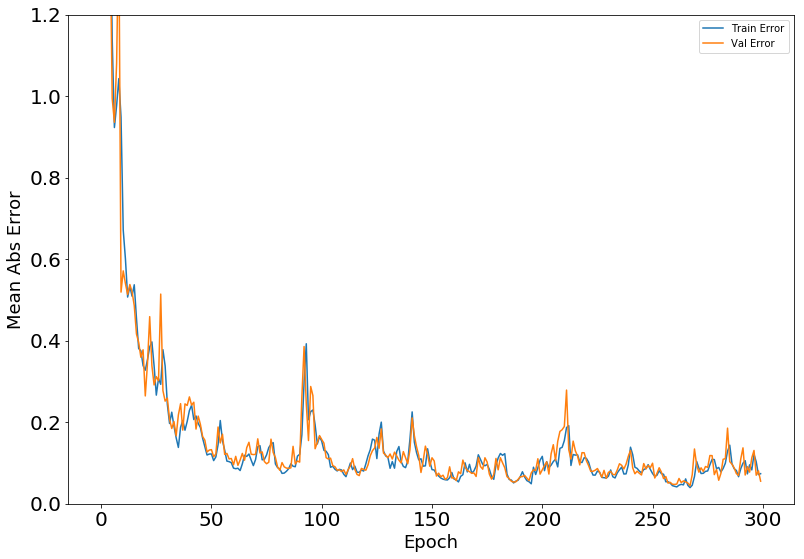

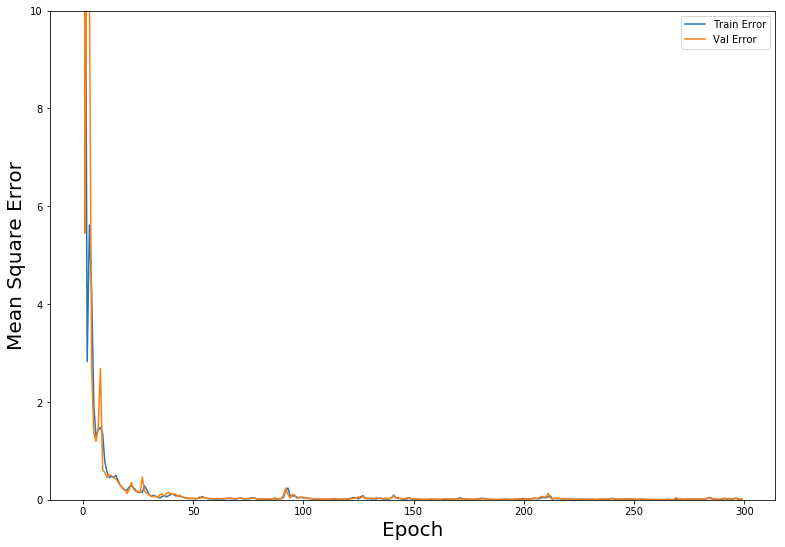

In [85]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
    
  plt.figure(figsize=(13,9))
  #plt.figure()
  plt.xlabel('Epoch', fontsize= 18)
  plt.ylabel('Mean Abs Error', fontsize= 18)
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,1.2])
  plt.tick_params(labelsize=20)
  plt.legend()
  

  plt.figure(figsize=(13,9))
  #plt.figure()
  plt.xlabel('Epoch', fontsize = 20)
  plt.ylabel('Mean Square Error', fontsize= 20)
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,10])
  plt.legend()
  plt.show()


plot_history(history)

**Save model**

(331, 2)
(331,)
(331,)


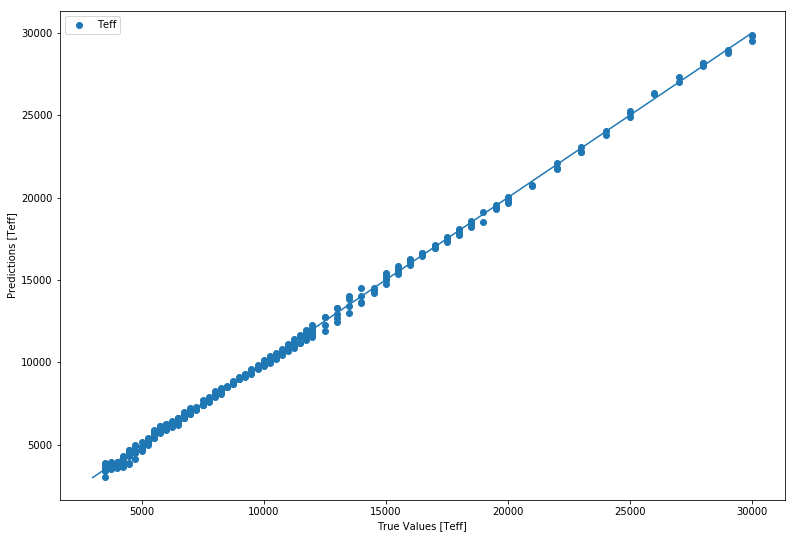

In [86]:
test_predictions = model.predict([x_RVStrain, x_BPtrain, x_RPtrain])
print(np.shape(test_predictions))
print(np.shape(y_train_stack[:,0]))
print(np.shape(y_train_stack[:,1]))
plt.figure(figsize=(13,9))
plt.scatter((denormalize(y_train_stack[:,0], mean_teff_train, std_teff_train )), denormalize(test_predictions[:,0], mean_teff_train, std_teff_train), label= 'Teff')
#plt.scatter((denormalize(y_train_stack[:,1], mean_logg, std_logg)), denormalize(test_predictions[:,1], mean_logg, std_teff), label= 'Log(g)')
plt.xlabel('True Values [Teff]')
plt.ylabel('Predictions [Teff]')
#plt.axis('equal')
#plt.axis('square')
plt.legend()
#plt.xlim([0,plt.xlim()[1]])
#plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([3000, 30000], [3000, 30000])
plt.show()

#print('test predictions=', test_predictions)

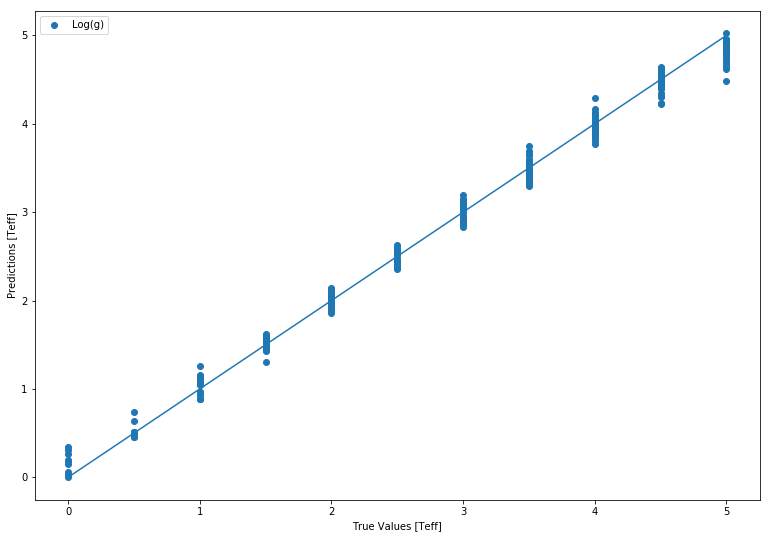

In [87]:
plt.figure(figsize=(13,9))
plt.scatter((denormalize(y_train_stack[:,1], mean_logg_train, std_logg_train)), denormalize(test_predictions[:,1], mean_logg_train, std_logg_train), label= 'Log(g)')
plt.xlabel('True Values [Teff]')
plt.ylabel('Predictions [Teff]')
_ = plt.plot([0, 5], [0, 5])
plt.legend()
plt.show()

In [88]:
#Unnormalizing the labels (teff)
''''
print(np.shape(y_train_stack[:,0]), y_train_stack[:,0])
print(np.shape(y_train_stack[:,1]))





plt.figure(figsize=(13,9))
test_predictions = model.predict([x_RVStrain, x_BPtrain, x_RPtrain])
print('shape of test_predictions:',np.shape(test_predictions))
print('print 10 elements of test_predictions:', test_predictions[0:10])
plt.scatter(denormalize(y_train_stack[:,0]), denormalize(test_predictions[:,0]), s= 4.0, c= 'r', label='Teff' )

print('teff',denormalize(y_train_stack[:,0]))
#plt.scatter(denormalize(y_train_stack[:,1]), denormalize(test_predictions[:,1]), s= 4.0, c= 'b', label='Log(g)' )
plt.xlabel(r"True", fontsize=25)
plt.ylabel(r"Prediction", fontsize=25)
plt.axis('equal')
plt.axis('square')
# increase the x,y tick label size
plt.tick_params(labelsize= 25) 
#plt.xlim([0,plt.xlim()[1]])
#plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-2, 4], [-2, 4], color='green')
plt.legend(fontsize=20)

'''''



'\'\nprint(np.shape(y_train_stack[:,0]), y_train_stack[:,0])\nprint(np.shape(y_train_stack[:,1]))\n\n\n\n\n\nplt.figure(figsize=(13,9))\ntest_predictions = model.predict([x_RVStrain, x_BPtrain, x_RPtrain])\nprint(\'shape of test_predictions:\',np.shape(test_predictions))\nprint(\'print 10 elements of test_predictions:\', test_predictions[0:10])\nplt.scatter(denormalize(y_train_stack[:,0]), denormalize(test_predictions[:,0]), s= 4.0, c= \'r\', label=\'Teff\' )\n\nprint(\'teff\',denormalize(y_train_stack[:,0]))\n#plt.scatter(denormalize(y_train_stack[:,1]), denormalize(test_predictions[:,1]), s= 4.0, c= \'b\', label=\'Log(g)\' )\nplt.xlabel(r"True", fontsize=25)\nplt.ylabel(r"Prediction", fontsize=25)\nplt.axis(\'equal\')\nplt.axis(\'square\')\n# increase the x,y tick label size\nplt.tick_params(labelsize= 25) \n#plt.xlim([0,plt.xlim()[1]])\n#plt.ylim([0,plt.ylim()[1]])\n_ = plt.plot([-2, 4], [-2, 4], color=\'green\')\nplt.legend(fontsize=20)\n\n'

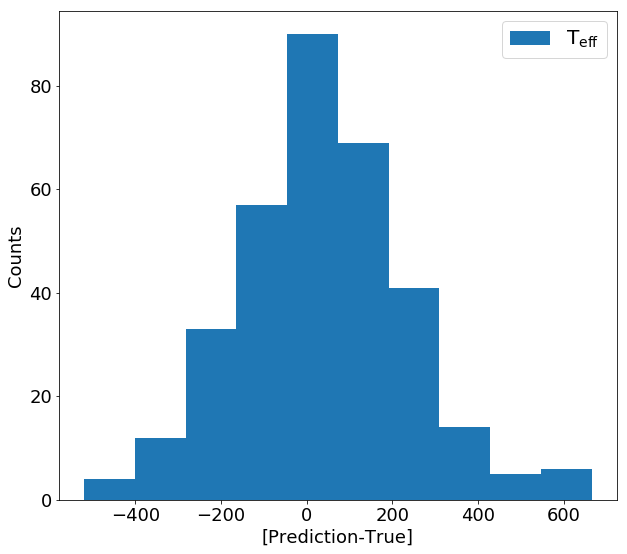

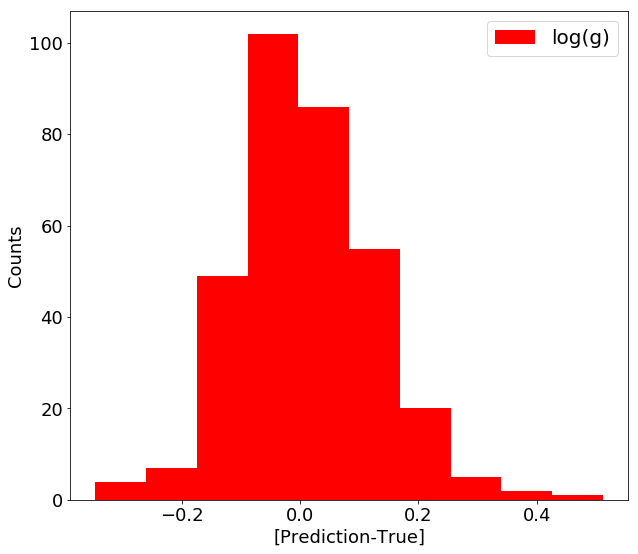

In [89]:
#Making the histogram of denormalized training set 

plt.figure(figsize=(10,9))
data_teff=np.subtract(denormalize(y_train_stack[:,0], mean_teff_train, std_teff_train), denormalize(test_predictions[:,0], mean_teff_train, std_teff_train)) 
data_logg=np.subtract(denormalize(y_train_stack[:,1], mean_logg_train, std_logg_train), denormalize(test_predictions[:,1], mean_logg_train, std_logg_train)) 

counts_teff, bins_teff = np.histogram(data_teff)
counts_logg, bins_logg = np.histogram(data_logg)

#histogram for LogTeff
plt.hist(bins_teff[:-1], bins_teff, weights=counts_teff, label= r'$\rm T_{\rm eff}$')
plt.tick_params(labelsize=18) 
plt.xlabel(r'[Prediction-True]', fontsize=18)
plt.ylabel('Counts', fontsize=18)
plt.legend(fontsize=20)
plt.show()

#histogram for Log(g)
plt.figure(figsize=(10,9))
plt.hist(bins_logg[:-1], bins_logg, weights=counts_logg, label= 'log(g)', color='red')
plt.tick_params(labelsize=18) 
plt.xlabel(r'[Prediction-True]', fontsize=18)
plt.ylabel('Counts', fontsize=18)
plt.legend(fontsize=20)
plt.show()




#print('standard deviation', len(z))
#print(len(z[teff<5000]))
#print(len(z))


# Training Data Set

In [90]:
# getting deviation in Teff bins

teffbin_edges=np.array( [4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000, 18000])
nbin = len(teffbin_edges)


# pred vs. true
# unnormalised values
teff_pred = denormalize(test_predictions[:,0], mean_teff_train, std_teff_train)
teff_true = denormalize(y_train_stack[:,0], mean_teff_train, std_teff_train) #teff values are created by read_spectra1_updatedwavelength from the nsc Allende Prieto spectra library
teff_diff = teff_pred-teff_true

# compute mean and std in Teff bins
teff_diff_mean = np.zeros(nbin) 
teff_diff_std = np.zeros(nbin)
teffbin_mean = np.zeros(nbin)

for i in range(nbin): #iterations(0,1,2,3,4)
    if i==0:
        indx = np.where(teff_true<teffbin_edges[i]) #index of teff_true where teff true< 5000 since teff has all values of teff in each library
        #print(indx)
    elif i==nbin-1: #if i= 5-1= 4
        indx = np.where(teff_true>teffbin_edges[i-1]) #index of true_teff>20000
    else: #if i=1,2,3
        indx = np.where((teff_true>teffbin_edges[i-1]) & (teff_true<teffbin_edges[i]))
        #if i=1, teff_true>(teffbin_edges[1-1=0]= 5000) & teff_true<teffbin_edges[1]= 10000, so 5000<teff<10000
        #if i=2, teff_true>(teffbin_edges[2-1=1]=10000) & teff_true<teffbin_edges[2]= 15000, so 10000<teff<15000
        #if i=3, teff_true> (teffbin_edges[3-1=2]= 15000) & teff_true<teffbin_edges[3]= 20000 so 15000<teff<20000
    teffbin_mean[i] = np.mean(teff_true[indx]) #calculating the mean values of teff_true from assigning its index in the for loop
    teff_diff_mean[i] = np.mean(teff_diff[indx]) #calculating the mean values of teff_diff from its index 
    teff_diff_std[i] = np.std(teff_diff[indx]) #calculating the std values of teff-diff from its index
    
print('mean of bin teff_true=', teffbin_mean)
print('mean of teff_diff=', teff_diff_mean)
print('std of teff_diff=', teff_diff_std)
print('length of teff_diff=', len(teff_diff))

####################################################################################################################
print('==========================================================================================================')
# getting deviation in Teff bins
loggbin_edges=np.array([ -2, -1, 0, 1, 2, 3, 4, 5])
nbin = len(loggbin_edges)


# pred vs. true
# unnormalised values
logg_pred = denormalize(test_predictions[:,1], mean_logg_train, std_logg_train)
logg_true = denormalize(y_train_stack[:,1], mean_logg_train, std_logg_train) #teff values are created by read_spectra1_updatedwavelength from the nsc Allende Prieto spectra library
logg_diff = logg_pred-logg_true

# compute mean and std in Teff bins
logg_diff_mean = np.zeros(nbin) 
logg_diff_std = np.zeros(nbin)
loggbin_mean = np.zeros(nbin)

for i in range(nbin): #iterations(0,1,2,3,4)
    if i==0:
        indx = np.where(logg_true<loggbin_edges[i]) #index of teff_true where teff true< 5000 since teff has all values of teff in each library
        #print(indx)
    elif i==nbin-1: #if i= 5-1= 4
        indx = np.where(logg_true>loggbin_edges[i-1]) #index of true_teff>20000
    else: #if i=1,2,3
        indx = np.where((logg_true>loggbin_edges[i-1]) & (logg_true<loggbin_edges[i]))

    loggbin_mean[i] = np.mean(logg_true[indx]) #calculating the mean values of teff_true from assigning its index in the for loop
    logg_diff_mean[i] = np.mean(logg_diff[indx]) #calculating the mean values of teff_diff from its index 
    logg_diff_std[i] = np.std(logg_diff[indx]) #calculating the std values of teff-diff from its index
    
print('mean of bin logg_true=', loggbin_mean)
print('mean of logg_diff=', logg_diff_mean)
print('std of logg_diff=', logg_diff_std)
print('length of logg_diff=', len(logg_diff))









mean of bin teff_true= [ 3640.625       4392.85714286  5548.07692308  6488.63636364
  7521.73913043  8500.          9527.77777778 10464.28571429
 11515.625      12500.         13500.         14500.
 15500.         16500.         22291.66666667]
mean of teff_diff= [  15.11724854 -172.43102679   90.17247596    3.26888761  -38.06494141
    5.32770647  -51.6547309  -139.48611886  -88.12548828  -94.37109375
   73.30175781 -169.60384115  120.46269531   57.63378906  -64.7750651 ]
std of teff_diff= [220.08394951 216.30360978 168.80766686 137.29638404  87.41682544
  77.40580697  85.10339955 149.3859777  192.35827639 349.54655283
 382.8704086  138.06949485 160.1720224   63.40752317 185.52149648]
length of teff_diff= 331
mean of bin logg_true= [       nan        nan        nan 0.5        1.5        2.5
 3.5        4.72631579]
mean of logg_diff= [        nan         nan         nan  0.03148042  0.01228706 -0.00264339
 -0.01110402 -0.07520148]
std of logg_diff= [       nan        nan        nan 0.0

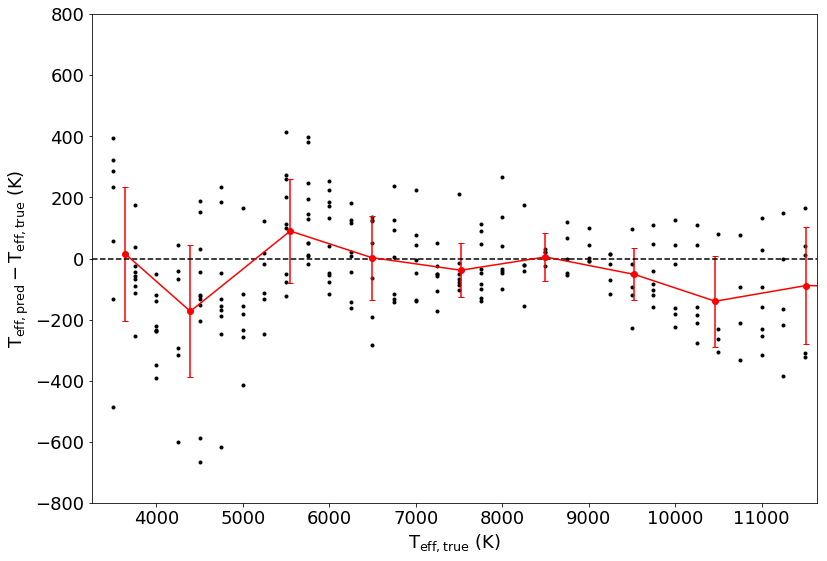

In [91]:
# plot of teff
plt.figure(figsize=(13,9))
# plot the difference
plt.scatter(teff_true, teff_diff ,c='k', marker='.')
#plt.plot(teff_true, teff_diff,'o', markersize=1, c='k')

# plot mean (symbol) and scatter with error bars
plt.errorbar(teffbin_mean, teff_diff_mean, yerr=teff_diff_std, fmt='-o', c='r',capsize=3) #plotting the teff bin mean in x-axis and teff_diff in y-axis

# increase the x,y tick label size
plt.tick_params(labelsize=18) 

# set x, y label. 
plt.xlabel(r"$T_{\rm eff,true}$ (K)", fontsize=18)
plt.ylabel(r"$T_{\rm eff,pred}-T_{\rm eff,true}$ (K)", fontsize=18)

# set x, y lim plot range
xlim=np.array([3250, 11640.76923077])
ylim=np.array([-800, 800])
plt.xlim(xlim[0],xlim[1]) #plotting the xlim
plt.ylim(ylim[0],ylim[1])

# set x, y label. 
plt.xlabel(r"$\rm T_{\rm eff,true}$ (K)", fontsize=18)
plt.ylabel(r"$\rm T_{\rm eff,pred}-\rm T_{\rm eff,true}$ (K)", fontsize=18)

# draw y=0 line
xline = np.linspace(xlim[0],xlim[1], 2)
yline = np.zeros_like(xline)
plt.plot(xline,yline,linestyle='--',c='k')





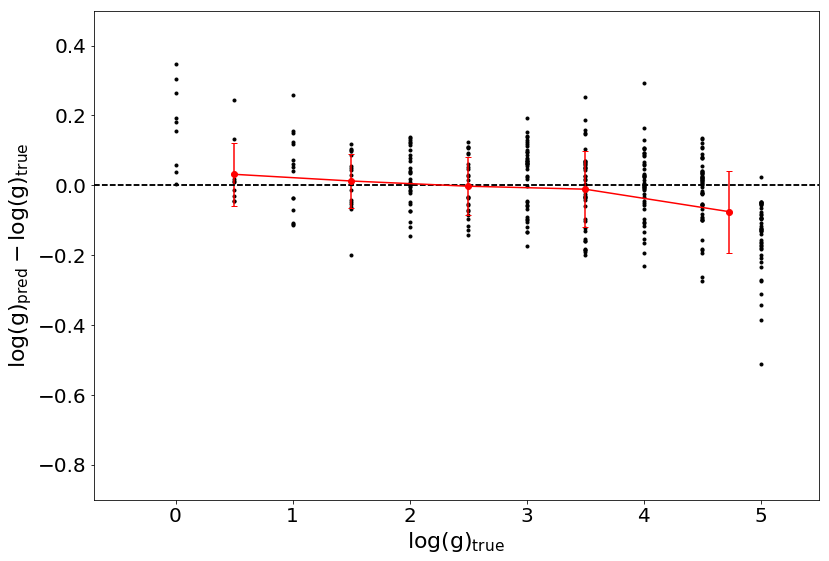

In [92]:
#Plot log 
plt.figure(figsize=(13,9))
# plot the difference
plt.scatter(logg_true, logg_diff ,c='k', marker='.')
#plt.plot(teff_true, teff_diff,'o', markersize=1, c='k')

# plot mean (symbol) and scatter with error bars
plt.errorbar(loggbin_mean,logg_diff_mean, yerr=logg_diff_std, fmt='-o', c='r',capsize=3) #plotting the teff bin mean in x-axis and teff_diff in y-axis

# increase the x,y tick label size
plt.tick_params(labelsize=20) 

# set x, y label. 
#plt.xlabel(r"$T_{\rm eff,true}$ (K)", fontsize=18)
#plt.ylabel(r"$T_{\rm eff,pred}-T_{\rm eff,true}$ (K)", fontsize=18)

# set x, y lim plot range
xlim=np.array([-0.7, 5.5])
ylim=np.array([-0.9, 0.5])
plt.xlim(xlim[0],xlim[1]) #plotting the xlim
plt.ylim(ylim[0],ylim[1])

# draw y=0 line
xline = np.linspace(xlim[0], xlim[1],2 )
yline = np.zeros_like(xline)
plt.plot(xline,yline,linestyle='--',c='k')

# set x, y label. 
plt.xlabel(r"$\rm log(g)_{\rm true}$", fontsize=22)
plt.ylabel(r"$\rm log(g)_{\rm pred}-\rm log(g)_{\rm true}$", fontsize=22)



# draw y=0 line
xline = np.linspace(xlim[0],xlim[1], 2)
yline = np.zeros_like(xline)
plt.plot(xline,yline,linestyle='--',c='k')




# Cross Validation Set

(84, 2)
(331,)
(331,)


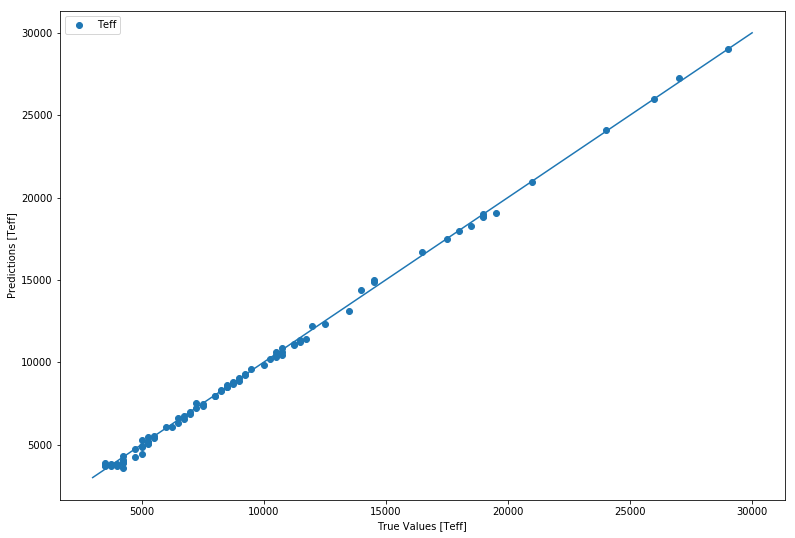

In [93]:
#Test set (x_cv)

test_predictions = model.predict([x_RVScv, x_BPcv, x_RPcv])
print(np.shape(test_predictions))
print(np.shape(y_train_stack[:,0]))
print(np.shape(y_train_stack[:,1]))
plt.figure(figsize=(13,9))
plt.scatter((denormalize(y_cv_stack[:,0], mean_teff_train, std_teff_train )), denormalize(test_predictions[:,0], mean_teff_train, std_teff_train), label= 'Teff')
#plt.scatter((denormalize(y_train_stack[:,1], mean_logg, std_logg)), denormalize(test_predictions[:,1], mean_logg, std_teff), label= 'Log(g)')
plt.xlabel('True Values [Teff]')
plt.ylabel('Predictions [Teff]')
#plt.axis('equal')
#plt.axis('square')
plt.legend()
_ = plt.plot([3000, 30000], [3000, 30000])
plt.show()
#plt.xlim([0,plt.xlim()[1]])
#plt.ylim([0,plt.ylim()[1]])
#_ = plt.plot([1.4, 1.4], [1.4, 1.4])

#print('test predictions=', test_predictions)


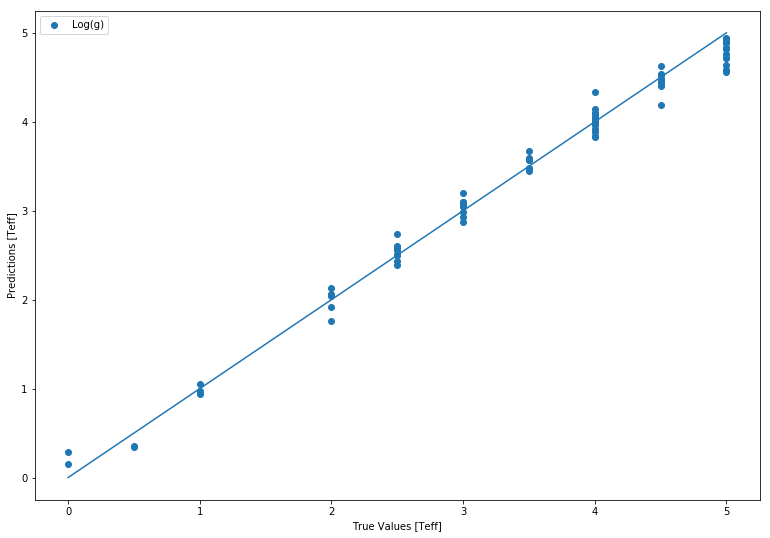

In [94]:
plt.figure(figsize=(13,9))
plt.scatter((denormalize(y_cv_stack[:,1], mean_logg_train, std_logg_train)), denormalize(test_predictions[:,1], mean_logg_train, std_logg_train), label= 'Log(g)')
plt.xlabel('True Values [Teff]')
plt.ylabel('Predictions [Teff]')
_ = plt.plot([0, 5], [0, 5])
plt.legend()
plt.show()

In [95]:
# getting deviation in Teff bins
teffbin_edges=np.array( [4000, 5000, 6000,  7000, 8000,  9000,  10000,  12000, 13000])
nbin = len(teffbin_edges)


# pred vs. true
# unnormalised values
teff_pred = denormalize(test_predictions[:,0], mean_teff_train, std_teff_train)
teff_true = denormalize(y_cv_stack[:,0], mean_teff_train, std_teff_train) #teff values are created by read_spectra1_updatedwavelength from the nsc Allende Prieto spectra library
teff_diff = teff_pred-teff_true

print(' Teff diff mean and std for Teff<11000=', np.mean(teff_diff[(teff_true>4000) & (teff_true<11000.0)]), 
      np.std(teff_diff[(teff_true>4000) & (teff_true<11000.0)]),
      len(teff_diff[(teff_true>4000) & (teff_true<11000.0)]))

print(' Teff diff mean and std for Teff<5000=', np.mean(teff_diff[(teff_true>3750) & (teff_true<5000)]), 
      np.std(teff_diff[(teff_true>3750) & (teff_true<5000)]),
      len(teff_diff[(teff_true>3750) & (teff_true<5000)]))

# compute mean and std in Teff bins
teff_diff_mean = np.zeros(nbin) 
teff_diff_std = np.zeros(nbin)
teffbin_mean = np.zeros(nbin)

for i in range(nbin): #iterations(0,1,2,3,4)
    if i==0:
        indx = np.where(teff_true<teffbin_edges[i]) #index of teff_true where teff true< 5000 since teff has all values of teff in each library
        #print(indx)
    elif i==nbin-1: #if i= 5-1= 4
        indx = np.where(teff_true>teffbin_edges[i-1]) #index of true_teff>20000
    else: #if i=1,2,3
        indx = np.where((teff_true>teffbin_edges[i-1]) & (teff_true<teffbin_edges[i]))
        #if i=1, teff_true>(teffbin_edges[1-1=0]= 5000) & teff_true<teffbin_edges[1]= 10000, so 5000<teff<10000
        #if i=2, teff_true>(teffbin_edges[2-1=1]=10000) & teff_true<teffbin_edges[2]= 15000, so 10000<teff<15000
        #if i=3, teff_true> (teffbin_edges[3-1=2]= 15000) & teff_true<teffbin_edges[3]= 20000 so 15000<teff<20000
    teffbin_mean[i] = np.mean(teff_true[indx]) #calculating the mean values of teff_true from assigning its index in the for loop
    teff_diff_mean[i] = np.mean(teff_diff[indx]) #calculating the mean values of teff_diff from its index 
    teff_diff_std[i] = np.std(teff_diff[indx]) #calculating the std values of teff-diff from its index
    
print('mean of bin teff_true=', teffbin_mean)
print('mean of teff_diff=', teff_diff_mean)
print('std of teff_diff=', teff_diff_std)
print('length of teff_diff=', len(teff_diff))

####################################################################################################################
print('==========================================================================================================')
# getting deviation in Teff bins

loggbin_edges=np.array([   1, 2, 3, 4, 5, 6])
nbin = len(loggbin_edges)

# pred vs. true
# unnormalised values
logg_pred = denormalize(test_predictions[:,1], mean_logg_train, std_logg_train)
logg_true = denormalize(y_cv_stack[:,1], mean_logg_train, std_logg_train) #teff values are created by read_spectra1_updatedwavelength from the nsc Allende Prieto spectra library
logg_diff = logg_pred-logg_true

print(' logg diff mean and std for 2<logg<5=', np.mean(logg_diff[(logg_true >2) & (logg_true<5)]),
       np.std(logg_diff[(logg_true>2) & (logg_true<5)]),
      len(logg_diff[(logg_true>2) & (logg_true<5)]))

# compute mean and std in Teff bins
logg_diff_mean = np.zeros(nbin) 
logg_diff_std = np.zeros(nbin)
loggbin_mean = np.zeros(nbin)

for i in range(nbin): #iterations(0,1,2,3,4)
    if i==0:
        indx = np.where(logg_true<loggbin_edges[i]) #index of teff_true where teff true< 5000 since teff has all values of teff in each library
        #print(indx)
    elif i==nbin-1: #if i= 5-1= 4
        indx = np.where(logg_true>loggbin_edges[i-1]) #index of true_teff>20000
    else: #if i=1,2,3
        indx = np.where((logg_true>loggbin_edges[i-1]) & (logg_true<loggbin_edges[i]))

    loggbin_mean[i] = np.mean(logg_true[indx]) #calculating the mean values of teff_true from assigning its index in the for loop
    logg_diff_mean[i] = np.mean(logg_diff[indx]) #calculating the mean values of teff_diff from its index 
    logg_diff_std[i] = np.std(logg_diff[indx]) #calculating the std values of teff-diff from its index
    
print('mean of bin logg_true=', loggbin_mean)
print('mean of logg_diff=', logg_diff_mean)
print('std of logg_diff=', logg_diff_std)
print('length of logg_diff=', len(logg_diff))







        

 Teff diff mean and std for Teff<11000= -82.66312210648151 180.21862065324743 54
 Teff diff mean and std for Teff<5000= -273.7903103298613 212.3754316401423 9
mean of bin teff_true= [ 3583.33333333  4305.55555556  5321.42857143  6550.
  7375.          8500.          9333.33333333 10937.5
 19055.55555556]
mean of teff_diff= [ 175.21459961 -273.79031033  -62.71205357  -91.77177734    7.92199707
   22.9312221    23.46516927 -137.99031576    7.03081597]
std of teff_diff= [125.65484877 212.37543164 116.73238899 123.91325348 147.74166251
  53.99307873  53.2816577  138.22460307 246.68068698]
length of teff_diff= 84
 logg diff mean and std for 2<logg<5= 0.020265030411054503 0.10530589420956982 53
mean of bin logg_true= [0.25  nan 2.5  3.5  4.5   nan]
mean of logg_diff= [ 0.03153282         nan  0.04129117  0.05498409 -0.04026328         nan]
std of logg_diff= [0.19063997        nan 0.08850233 0.07294611 0.11263082        nan]
length of logg_diff= 84


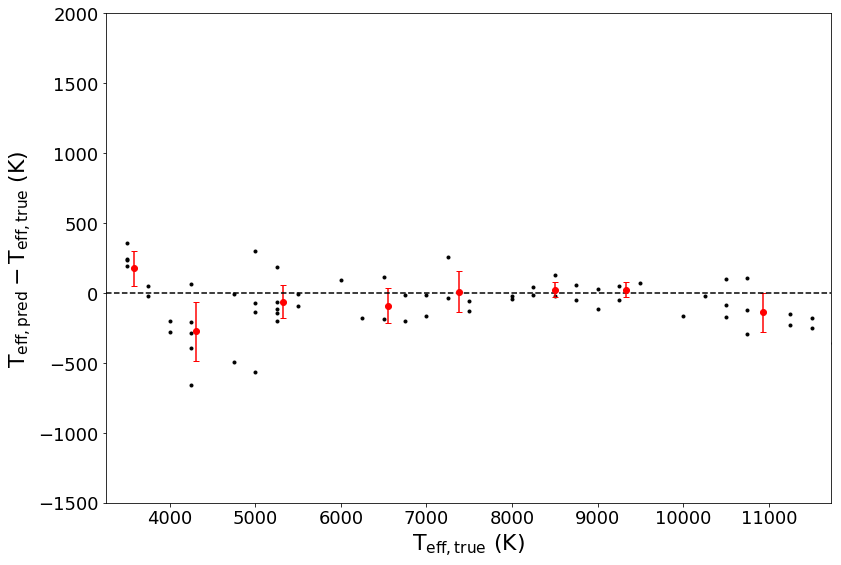

In [96]:
# plot of logteff
plt.figure(figsize=(13,9))
# plot the difference
plt.scatter(teff_true, teff_diff ,c='k', marker='.')
#plt.plot(teff_true, teff_diff,'o', markersize=1, c='k')

# plot mean (symbol) and scatter with error bars
plt.errorbar(teffbin_mean, teff_diff_mean, yerr=teff_diff_std, fmt='o', c='r',capsize=3) #plotting the teff bin mean in x-axis and teff_diff in y-axis

# increase the x,y tick label size
plt.tick_params(labelsize=18) 

# set x, y label. 
plt.xlabel(r"$T_{\rm eff,true}$ (K)", fontsize=22)
plt.ylabel(r"$T_{\rm eff,pred}-T_{\rm eff,true}$ (K)", fontsize=22)

# set x, y lim plot range
xlim=np.array([3250,  11725])
ylim=np.array([-1500, 2000])
plt.xlim(xlim[0],xlim[1]) #plotting the xlim
plt.ylim(ylim[0],ylim[1])

# set x, y label. 
plt.xlabel(r"$\rm T_{\rm eff,true}$ (K)", fontsize=22)
plt.ylabel(r"$\rm T_{\rm eff,pred}-\rm T_{\rm eff,true}$ (K)", fontsize=22)

# draw y=0 line
xline = np.linspace(xlim[0],xlim[1], 2)
yline = np.zeros_like(xline)
plt.plot(xline,yline,linestyle='--',c='k')






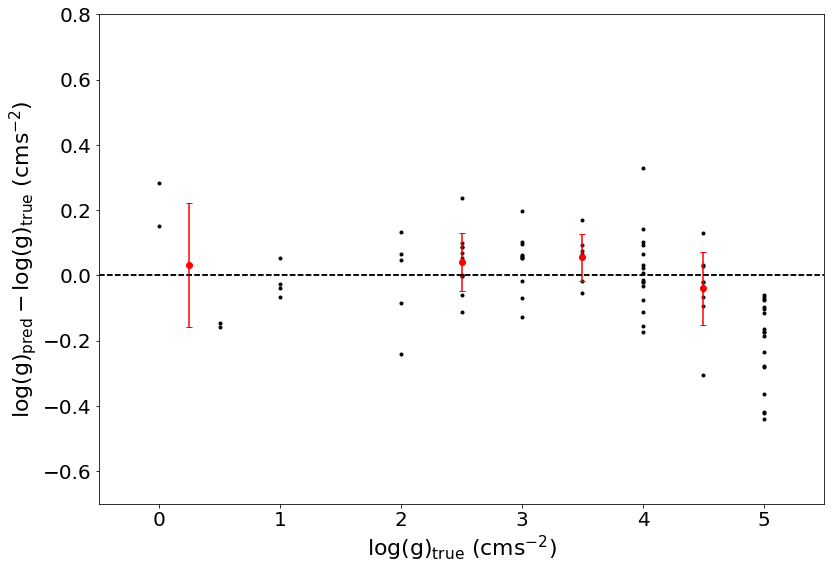

In [97]:
#Plot log 
plt.figure(figsize=(13,9))
# plot the difference
plt.scatter(logg_true, logg_diff ,c='k', marker='.')
#plt.plot(teff_true, teff_diff,'o', markersize=1, c='k')

# plot mean (symbol) and scatter with error bars
plt.errorbar(loggbin_mean,logg_diff_mean, yerr=logg_diff_std, fmt='o', c='r',capsize=3) #plotting the teff bin mean in x-axis and teff_diff in y-axis

# increase the x,y tick label size
plt.tick_params(labelsize=20) 

# set x, y label. 
#plt.xlabel(r"$T_{\rm eff,true}$ (K)", fontsize=18)
#plt.ylabel(r"$T_{\rm eff,pred}-T_{\rm eff,true}$ (K)", fontsize=18)

# set x, y lim plot range
xlim=np.array([-0.5, 5.5])
ylim=np.array([-0.7, 0.8])
plt.xlim(xlim[0],xlim[1]) #plotting the xlim
plt.ylim(ylim[0],ylim[1])

# draw y=0 line
xline = np.linspace(xlim[0], xlim[1],2 )
yline = np.zeros_like(xline)
plt.plot(xline,yline,linestyle='--',c='k')

# set x, y label. 
plt.xlabel(r"$\rm log(g)_{\rm true}$ $(\rm cm s^{-2})$", fontsize=22)
plt.ylabel(r"$\rm log(g)_{\rm pred}-\rm log(g)_{\rm true}$ $(\rm cm s^{-2})$", fontsize=22)



# draw y=0 line
xline = np.linspace(xlim[0],xlim[1], 2)
yline = np.zeros_like(xline)
plt.plot(xline,yline,linestyle='--',c='k')



In [99]:
# Input spectra
input_spec = Input(shape=(num_fluxes,), name='starnet_input_x')

# Reshape spectra for CNN layers
cur_in = Reshape((num_fluxes, 1))(input_spec)

# CNN layers
# First
cur_in = Conv1D(kernel_initializer=initializer, activation=activation, 
                padding="same", filters=128, kernel_size=32)(cur_in) #first CNN layer
# Max pooling layer
cur_in = MaxPooling1D(pool_size=32)(cur_in)
# Second CNN layer
cur_in = Conv1D(kernel_initializer=initializer, activation=activation,
                padding="same", filters=128, kernel_size=16)(cur_in) #2nd CNN layer
# Max pooling layer
cur_in = MaxPooling1D(pool_size=16)(cur_in)
# Third CNN layer
cur_in = Conv1D(kernel_initializer=initializer, activation=activation,
                padding="same", filters=128, kernel_size=8)(cur_in) #2nd CNN layer
# Max pooling layer
cur_in = MaxPooling1D(pool_size=8)(cur_in)

# Flatten the current input for the fully-connected layers
cur_in = Flatten()(cur_in)

# Fully-connected layers
cur_in = Dense(units=258, kernel_initializer=initializer, 
               activation=activation)(cur_in)
cur_in = Dense(units=128, kernel_initializer=initializer, 
               activation=activation)(cur_in)

# Output nodes
output_label = Dense(units=num_labels, kernel_regularizer=keras.regularizers.l2(0.01), activation="linear", 
                     input_dim=num_hidden[1])(cur_in)

model = Model(input_spec, output_label)

ValueError: Negative dimension size caused by subtracting 8 from 1 for 'max_pooling1d_12/MaxPool' (op: 'MaxPool') with input shapes: [?,1,1,128].

In [16]:
optimizer = Adam(lr=0.0005)

In [97]:
# loss function to minimize
loss_function = 'mean_squared_error'
optimizer = 'adadelta'
# compute mean absolute deviation
metrics = ['mae', 'mse']
#metrics = ['mae']
model.compile(optimizer=optimizer, loss=loss_function, metrics=metrics)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
starnet_input_x (InputLayer) (None, 6758)              0         
_________________________________________________________________
reshape_10 (Reshape)         (None, 6758, 1)           0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 6758, 128)         4224      
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 211, 128)          0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 211, 128)          262272    
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 13, 128)           0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 13, 128)           131200    
__________

In [ ]:
history = model.fit(x_train, y_train, 
          epochs=max_epochs, validation_split = 0.2, verbose=1, shuffle='batch')

Train on 875 samples, validate on 219 samples
Epoch 1/200
875/875 [==============================] - 13s 15ms/step - loss: 5.2174 - mean_absolute_error: 1.4147 - mean_squared_error: 5.1988 - val_loss: 1.5482 - val_mean_absolute_error: 0.9417 - val_mean_squared_error: 1.5305
Epoch 2/200
875/875 [==============================] - 12s 14ms/step - loss: 0.3955 - mean_absolute_error: 0.5094 - mean_squared_error: 0.3783 - val_loss: 1.8217 - val_mean_absolute_error: 1.0313 - val_mean_squared_error: 1.8050
Epoch 3/200
875/875 [==============================] - 12s 14ms/step - loss: 0.3606 - mean_absolute_error: 0.4579 - mean_squared_error: 0.3443 - val_loss: 1.9750 - val_mean_absolute_error: 1.0742 - val_mean_squared_error: 1.9589
Epoch 4/200
875/875 [==============================] - 12s 14ms/step - loss: 0.3806 - mean_absolute_error: 0.4960 - mean_squared_error: 0.3648 - val_loss: 2.0388 - val_mean_absolute_error: 1.0894 - val_mean_squared_error: 2.0232
Epoch 5/200
875/875 [=================

Epoch 72/200
875/875 [==============================] - 12s 14ms/step - loss: 0.0399 - mean_absolute_error: 0.1346 - mean_squared_error: 0.0361 - val_loss: 1.6221 - val_mean_absolute_error: 0.9613 - val_mean_squared_error: 1.6183
Epoch 73/200
875/875 [==============================] - 13s 14ms/step - loss: 0.0413 - mean_absolute_error: 0.1380 - mean_squared_error: 0.0375 - val_loss: 1.5695 - val_mean_absolute_error: 0.9410 - val_mean_squared_error: 1.5657
Epoch 74/200
875/875 [==============================] - 12s 14ms/step - loss: 0.0508 - mean_absolute_error: 0.1554 - mean_squared_error: 0.0470 - val_loss: 1.6579 - val_mean_absolute_error: 0.9698 - val_mean_squared_error: 1.6541
Epoch 75/200
875/875 [==============================] - 12s 14ms/step - loss: 0.0419 - mean_absolute_error: 0.1415 - mean_squared_error: 0.0381 - val_loss: 1.9499 - val_mean_absolute_error: 1.0596 - val_mean_squared_error: 1.9461
Epoch 76/200
875/875 [==============================] - 12s 14ms/step - loss: 0.

875/875 [==============================] - 12s 13ms/step - loss: 0.0267 - mean_absolute_error: 0.1066 - mean_squared_error: 0.0241 - val_loss: 1.3541 - val_mean_absolute_error: 0.8321 - val_mean_squared_error: 1.3514
Epoch 143/200
875/875 [==============================] - 13s 14ms/step - loss: 0.0540 - mean_absolute_error: 0.1430 - mean_squared_error: 0.0514 - val_loss: 1.8749 - val_mean_absolute_error: 1.0292 - val_mean_squared_error: 1.8723
Epoch 144/200
875/875 [==============================] - 12s 14ms/step - loss: 0.0324 - mean_absolute_error: 0.1221 - mean_squared_error: 0.0298 - val_loss: 1.3159 - val_mean_absolute_error: 0.8185 - val_mean_squared_error: 1.3133
Epoch 145/200
875/875 [==============================] - 12s 14ms/step - loss: 0.0255 - mean_absolute_error: 0.0968 - mean_squared_error: 0.0230 - val_loss: 1.3150 - val_mean_absolute_error: 0.8193 - val_mean_squared_error: 1.3124
Epoch 146/200
875/875 [==============================] - 12s 14ms/step - loss: 0.0254 - me

In [32]:
hist = pd.DataFrame(history.history)
hist['epoch']= history.epoch
hist.tail()

,val_loss,val_mean_absolute_error,val_mean_squared_error,loss,mean_absolute_error,mean_squared_error,epoch
195,6.650632e+07,6355.818481,6.650632e+07,1.702399e+06,881.769361,1.702399e+06,195
196,6.275853e+07,6161.197162,6.275853e+07,1.711892e+06,930.596856,1.711892e+06,196
197,5.944006e+07,5997.135702,5.944006e+07,1.580298e+06,893.164042,1.580298e+06,197
198,6.229281e+07,6138.579988,6.229281e+07,1.912179e+06,979.157146,1.912179e+06,198
199,6.106594e+07,6076.085226,6.106594e+07,1.614590e+06,912.569914,1.614590e+06,199


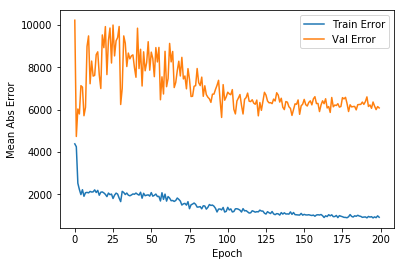

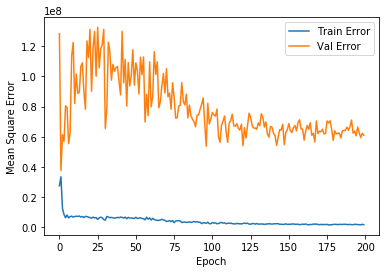

In [33]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  #plt.ylim([0,5])
  plt.legend()
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  #plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

test predictions= [ 6836.807   6837.5747  6836.7603 ... 10159.98   12968.633  12631.623 ]


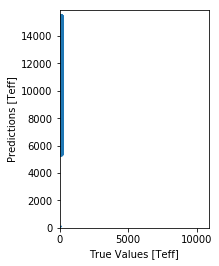

In [34]:
test_predictions = model.predict(norm_flux).flatten()

plt.scatter(normalize(teff), test_predictions)
plt.xlabel('True Values [Teff]')
plt.ylabel('Predictions [Teff]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

print('test predictions=', test_predictions)